# Фильтрация, нормализация, удаление шума, выравнивание облаков точек в Open3D

In [1]:
import numpy as np
import plotly.graph_objects as go

class DisplayFigs:
    def _rgb_to_hex(rgb):
        '''Convert colors to Plotly hex color strings'''
        rgb255 = (rgb * 255).astype(int)
        return ['rgb({},{},{})'.format(r, g, b) for r, g, b in rgb255]


    def display_plotly_orig_and_clouds(orig_fig, cloud_figs: set):
        # Extract metadata for origin figure
        verts_fig = np.asarray(orig_fig.vertices)
        tris_fig = np.asarray(orig_fig.triangles)
        orig_colors = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(verts_fig.shape, [128/255, 26/255, 107/255])

        # Exrtact metadata for cloud figures
        cloud_figs_points = []
        cloud_figs_colors_hex = []
        for cloud_fig in cloud_figs:
            cloud_figs_points.append(np.asarray(cloud_fig.points))

            fig_colors = np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([0, 0, 1], (len(cloud_fig.points), 1))
        
            cloud_figs_colors_hex.append(DisplayFigs._rgb_to_hex(fig_colors))

        orig_trace = go.Mesh3d(
            x=verts_fig[:, 0], y=verts_fig[:, 1], z=verts_fig[:, 2],
            i=tris_fig[:, 0], j=tris_fig[:, 1], k=tris_fig[:, 2],
            vertexcolor=orig_colors,
            opacity=0.8,
            showlegend=False,
            name=''
        )

        cloud_figs_trace = []
        for points, colors in zip(cloud_figs_points, cloud_figs_colors_hex):
            cloud_figs_trace.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=colors),
                showlegend=False,
                name=''
            ))

        merged_trace = [orig_trace,] + cloud_figs_trace

        fig = go.Figure(data=merged_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_origs(orig_figs: set):
        traces = []
        for orig_fig in orig_figs:
            vertices = np.asarray(orig_fig.vertices)
            triangles = np.asarray(orig_fig.triangles)
            color = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(vertices.shape, [128/255, 26/255, 107/255])

            traces.append(
                go.Mesh3d(
                    x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
                    i=triangles[:, 0], j=triangles[:, 1], k=triangles[:, 2],
                    vertexcolor=color,
                    opacity=0.8,
                    showlegend=False,
                    name=''
                )
            )

        fig = go.Figure(data=traces)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_clouds(cloud_figs: set):
        cloud_figs_trace = []
        for cloud_fig in cloud_figs:
            points = np.asarray(cloud_fig.points)
            color = DisplayFigs._rgb_to_hex(
                np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([0, 0, 1], (len(cloud_fig.points), 1))
            )

            cloud_figs_trace.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=color),
                showlegend=False,
                name=''
            ))

        fig = go.Figure(data=cloud_figs_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})

## 1. Импорт библиотек и проверка версий

Проверка версий важна для воспроизводимости: одинаковые параметры должны давать сопоставимые результаты.


In [2]:
import open3d as o3d
import numpy as np
import copy

print("Версия Open3D:", o3d.__version__)
print("Версия NumPy:", np.__version__)

Версия Open3D: 0.19.0
Версия NumPy: 1.26.4


## 2. Загрузка данных

### Загрузка стандартного облака

In [3]:
ply = o3d.data.PLYPointCloud()
pcd_raw = o3d.io.read_point_cloud(ply.path)

display(type(pcd_raw))
# DisplayFigs.display_plotly_clouds((pcd_raw,))

open3d.cpu.pybind.geometry.PointCloud

### Базовая статистика и характерный размер d

In [4]:
pts = np.asarray(pcd_raw.points)
mins = pts.min(axis=0) # [x_min, y_min, z_min]
maxs = pts.max(axis=0) # [x_max, y_max, z_max]
extent = maxs - mins   # [lx, ly, lz]
d = float(np.max(extent)) # характерный размер (макс. протяжённость)

print(f"Исходное облако: {len(pts)} точек")
print("mins:", mins, "maxs:", maxs, "extent:", extent, sep="\n")
print("d =", d)

Исходное облако: 196133 точек
mins:
[0.55859375 0.83203125 0.56663716]
maxs:
[3.96608973 2.42747617 2.55859375]
extent:
[3.40749598 1.59544492 1.99195659]
d = 3.4074959754943848


### Формируем облако с искажениями

In [ ]:
# Параметры искажений
rng = np.random.default_rng(42)
sigma_rel = 0.005 # шум как доля от d
p_out = 0.01 # доля выбросов (1%)
bbox_expand = 1.3 # во сколько раз расширяем bbox для выбросов

# Добавление Гауссова шума к исходным точкам
sigma = sigma_rel * d
noise = rng.normal(0.0, sigma, size=pts.shape)
pts_noisy = pts + noise
# display(pts_noisy)

# Генерация редких выбросов в расширенном bbox
center = 0.5 * (mins + maxs)
half = 0.5 * extent * bbox_expand
n_out = int(np.round(p_out * len(pts)))
outs = rng.uniform(low=center - half, high=center + half, size=(n_out, 3))

# Формирование искажённого облака
pts_aug = np.vstack([pts_noisy, outs])
pcd_aug = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts_aug))
# display(pcd_aug)

idx_inliers = np.arange(len(pts)) # индексы исходных точек (с шумом)
idx_outliers = np.arange(len(pts), len(pts_aug)) # индексы сгенерированных выбросов

pcd_corrupted = copy.deepcopy(pcd_aug)

# Добавление дубликатов
pts = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [1.0, 1.0, 1.0]
], dtype=np.float64)
pts_dup = np.vstack([pts, pts, pts])
pcd_dup = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts_dup))

# Добавляем невалидные точки
invalid_points = np.array([
    [np.nan, 0.0, 0.0],
    [np.inf, 0.0, 0.0]
])
pcd_nan = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(invalid_points))

pcd_corrupted = pcd_aug + pcd_dup + pcd_nan

print(f"Добавлено шума: σ = {sigma:.6f} ({sigma_rel:.3%} от d)")
print(f"Добавлено выбросов: {n_out} точек ({p_out:.2%} от исходного количества)")
print(f"Итоговое облако: {len(pts_aug)} точек")

# o3d.visualization.draw_geometries([pcd_corrupted])
DisplayFigs.display_plotly_clouds((pcd_corrupted,))

## 3. Очистка данных (удаление NaN, Inf, дубликатов, невалидных точек)

Open3D предоставляет два базовых метода очистки:

* remove_non_finite_points()

* remove_duplicated_points()

* Невалидные точки (NaN, Inf):

    точки, координаты которых содержат неопределённые (NaN) или бесконечные (Inf) значения.
    Такие точки могут появляться при ошибках сенсора, делении на ноль, преобразованиях координат и т.д.
    Они нарушают работу алгоритмов поиска соседей и расчёта нормалей.

* Дубликаты точек:

    точки с полностью совпадающими координатами.
    Возникают при объединении нескольких сканов или при повторной записи данных с датчика.
    Дубликаты увеличивают размер данных и мешают статистическим методам.

In [7]:
pcd_dedupl = copy.deepcopy(pcd_corrupted)

pcd_dedupl = pcd_dedupl.remove_duplicated_points()
print(f"Удалено дублирующихся точек: {len(pcd_corrupted.points) - len(pcd_dedupl.points)}")

Удалено дублирующихся точек: 10


In [9]:
pcd_clean = copy.deepcopy(pcd_dedupl)

pcd_clean = pcd_clean.remove_non_finite_points(
    remove_nan=True,
    remove_infinite=True
)
print(f"Удалено невалидных точек: {len(pcd_clean.points) - len(pcd_aug.points)}")

Удалено невалидных точек: 5


In [ ]:
DisplayFigs.display_plotly_clouds((pcd_clean,))

## 4. Фильтрация и даунсэмплинг

#### Цель

Снизить размерность данных, убрать избыточные точки и привести облако к «рабочему» объёму без существенной потери формы и топологии. На этом шаге мы не боремся с шумом, а контролируем плотность и ограничиваем область интереса.

Классический воксельный даунсэмплинг:
* всё пространство покрывается 3D-решёткой из кубов размера voxel_size
* из каждой непустой ячейки берётся один представитель(в Open3D — центроид точек в ячейке)
* цвета/нормали, если есть, усредняются

#### Воксельная фильтрация `voxel_down_sample(voxel_size)`

**Смысл:**
делит пространство на кубы (воксели) заданного размера `voxel_size` и заменяет все точки внутри куба одной усреднённой точкой.

**Параметры:**

* `voxel_size` — длина ребра вокселя (в единицах координат).
  
  * Типичные значения - `voxel_size=k⋅d`, где `k=0.01–0.05`
  * Больше `voxel_size` - меньше точек, сильнее сглаживание мелких деталей, выше риск слипания близких тонких структур.
  * Меньше `voxel_size` - ближе к исходной плотности, но слабее эффект уменьшения данных.

**Когда применять:**

* Перед вычислением нормалей/фичей и/или перед регистрацией, чтобы снизить вычислительные затраты.
* Для выравнивания неоднородной плотности датчика (LiDAR/стерео) до контролируемой сетки.

**Не рекомендуется:**

* если нужна высокая детализация мелких структур;
* при сильной неоднородности плотности (возможна потеря информации в разрежённых зонах).
* если требуется сохранить индексы исходных точек для последующего сопоставления (этот метод их не возвращает).

In [ ]:
pcd_work = copy.deepcopy(pcd_clean)

voxel_size = 0.01 * d  # пример: 1% от протяжённости
pcd_voxel = pcd_work.voxel_down_sample(voxel_size=voxel_size)

print(len(pcd_work.points), "--->", len(pcd_voxel.points), "точек")

DisplayFigs.display_plotly_clouds((pcd_voxel,))

#### Воксельная фильтрация с трассировкой `voxel_down_sample_and_trace(voxel_size, ...)`

Та же воксельная фильтрация, но возвращает также индексы исходных точек, попавших в каждый воксель.

**Параметры:**

* `voxel_size` — аналогично предыдущему методу;
* дополнительные аргументы (`min_bound`, `max_bound`) — опциональные ограничения по объёму(`get_min_bound()`/`get_max_bound()`)
* `approximate_class`:

    False (по умолчанию):

    * Используется точное прореживание
    * Каждая точка помещается в конкретный воксель
    * Сохраняется точная геометрическая информация
    
    True:

    * Активируется режим приблизительной классификации
    * Может использоваться более быстрая, но менее точная аппроксимация
    * Возможно снижение точности, но увеличение скорости обработки

**Когда применять:**
нужно сопоставлять усреднённые точки с исходными (например, при оценке потерь данных).

In [ ]:
voxel_size = 0.01 * d
min_bound = pcd_work.get_min_bound()
max_bound = pcd_work.get_max_bound()

pcd_voxel_tr, _, pt_map = pcd_work.voxel_down_sample_and_trace(
    voxel_size=voxel_size,
    min_bound=min_bound,
    max_bound=max_bound,
    approximate_class=False
)

# pt_map — список списков индексов исходных точек, усреднённых в каждой воксельной точке
n_mapped = sum(len(ix) for ix in pt_map)
print("Вокселей:", len(pcd_voxel_tr.points))
print("Cопоставленных исходных точек:", n_mapped)
print(len(pt_map), "вокселей", "--->", n_mapped, "точек")

DisplayFigs.display_plotly_clouds((pcd_voxel_tr,))

In [12]:
# pt_map

#### Равномерное прореживание `uniform_down_sample(every_k_points)`

берёт каждую k-ю точку из массива без пространственного анализа.

**Параметры:**

* `every_k_points` — шаг выборки.
  Например, `k = 10` означает, что сохраняется 10 % точек.

**Когда применять:**

* облако уже равномерное, но избыточное по числу точек;
* нужна очень быстрая предварительная фильтрация.

**Не рекомендуется:**

* если плотность точек различается по областям — выборка может исказить структуру.

In [ ]:
k = 10  # оставить каждую 10-ю точку
pcd_uniform = pcd_work.uniform_down_sample(every_k_points=k)
print(len(pcd_work.points), "--->", len(pcd_uniform.points), "точек")

DisplayFigs.display_plotly_clouds((pcd_uniform,))

#### Обрезка по ограничивающему объёму `crop(bounding_box)`

Обрезка облака по ограничивающему объёму.

Используется для выделения области интереса.

**Параметры:**

* `bounding_box` — объект типа

  * `o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)` или
  * `o3d.geometry.OrientedBoundingBox(center, R, extent)`.

**Использовать когда:**

* нужно выделить фрагмент сцены или исключить фон;
* полезно перед дальнейшими вычислениями нормалей и выравниванием.

##### Осевой параллелепипед (AABB)

In [ ]:
aabb = pcd_work.get_axis_aligned_bounding_box()
aabb = aabb.scale(0.6, aabb.get_center())  # сузить область до 60% вокруг центра
pcd_crop_aabb = pcd_work.crop(aabb)
print(len(pcd_work.points), "--->", len(pcd_crop_aabb.points))

# o3d.visualization.draw_geometries([pcd_crop_aabb])
DisplayFigs.display_plotly_clouds((pcd_crop_aabb,))

##### Ориентированный параллелепипед (OBB)

In [ ]:
obb = pcd_work.get_oriented_bounding_box()
obb = obb.scale(0.6, obb.get_center())
pcd_crop_obb = pcd_work.crop(obb)
print(len(pcd_work.points), "--->", len(pcd_crop_obb.points))

# o3d.visualization.draw_geometries([pcd_crop_obb])
DisplayFigs.display_plotly_clouds((pcd_crop_obb,))

#### Выбор по индексам `select_by_index(indices, invert=False)`

Выборка или исключение подмножества точек по индексам.

**Параметры:**

* `indices` — список индексов точек;
* `invert=False` — при `True` возвращает противоположное множество.

**Когда использовать:**

* есть предварительно вычисленная маска (например, результат фильтра по расстоянию, плотности и т.д.);
* нужно исключить выбросы, помеченные ранее.

In [ ]:
z = pts[:, 2]
thr = np.percentile(z, 0.95)
idx_high = np.where(z >= thr)[0]

# Исключить верхние 5%
pcd_keep = pcd_work.select_by_index(idx_high, invert=True)
print(len(pcd_work.points), "→", len(pcd_keep.points))

# o3d.visualization.draw_geometries([pcd_keep])
DisplayFigs.display_plotly_clouds((pcd_keep,))

В практической задаче обычно выбирают 1–2 метода:

* предпочтение voxel_down_sample для геометрически обоснованного упрощения;

* uniform_down_sample — для очень быстрого предварительного уменьшения;

* crop/select_by_index — для выделения области интереса.

## 5. Удаление шума и выбросов

**Цель**: удалить точки, не согласующиеся с локальной геометрией облака. Показываем оба метода Open3D: статистический и радиусный. Для демонстрации применяем их по отдельности к одной и той же копии входного облака.

* **Статистический выброс** — точка, средняя дистанция до её ближайших соседей существенно больше, чем у большинства точек.

* **Радиусный выброс** — точка, у которой недостаточно соседей в фиксированном радиусе.

### Статистическая фильтрация: `remove_statistical_outlier(nb_neighbors, std_ratio)`

**Параметры**

* `nb_neighbors = k` — число соседей для оценки средней дистанции.

  Рекомендации: 16–50; для плотных облаков увеличивать.
* `std_ratio` — порог в долях стандартного отклонения.

  Рекомендации: 1.0–3.0; меньше — строже, больше — мягче.

**Когда использовать**

* Неоднородная плотность (разные зоны сцены).
* Сцены с переменной дискретизацией сенсора.
* Когда нет естественного масштаба радиуса.

In [ ]:
pcd_sor_in = copy.deepcopy(pcd_work)

k = 32 # число соседей
std_ratio = 2.0 # строгость порога

pcd_sor, ind_inliers = pcd_sor_in.remove_statistical_outlier(
    nb_neighbors=k,
    std_ratio=std_ratio
)

# ind_inliers — индексы оставленных (хороших) точек
pcd_sor_kept = pcd_sor_in.select_by_index(ind_inliers, invert=False)
pcd_sor_removed = pcd_sor_in.select_by_index(ind_inliers, invert=True)

print("Статистическая фильтрация:",
      len(pcd_sor_in.points), "--->", len(pcd_sor_kept.points), "точек")


# o3d.visualization.draw_geometries([pcd_sor_kept])
# o3d.visualization.draw_geometries([pcd_sor_removed])
DisplayFigs.display_plotly_clouds((pcd_sor_kept,))
DisplayFigs.display_plotly_clouds((pcd_sor_removed,))

### Радиусная фильтрация: `remove_radius_outlier(nb_points, radius)`

**Параметры**

* `radius` — метрический радиус окрестности.

  Рекомендации: привязать к масштабу дискретизации
* `nb_points` — минимально допустимое число соседей в этом радиусе.

  Рекомендации: 5–20; выше — строже.

**Когда использовать**

* Более или менее равномерная плотность.
* Есть представление о физическом масштабе сцены или вокселя.
* Нужно жёстко отсечь разрежённые точки.

**Выбор радиуса (эвристика)**

* Если был воксельный даунсэмплинг с `voxel_size = v`, начать с `radius ≈ 1.5–2.5 * v`.
* Без воксельного шага: оценить среднюю дистанцию до k-го соседа и взять множитель.

### Зачем мы оцениваем среднюю дистанцию до k-го соседа

#### Мы ищем характерный радиус, который описывает среднее расстояние между соседними точками в облаке.

Этот радиус нужен для настройки параметра radius в методе
`remove_radius_outlier(nb_points, radius)`.

Если задать `radius` слишком маленьким — алгоритм решит, что почти у всех точек мало соседей, и удалит слишком много.
Если слишком большим — выбросы не удалятся вовсе.

Поэтому мы сначала оцениваем характерное расстояние между точками, чтобы задать разумный масштаб для фильтрации.

Для каждого выбранного набора точек \(p_i\) находим расстояние до k-го ближайшего соседа \(d_k(i)\). Средняя характерная дистанция:

$$
\bar{d}_k = \frac{1}{n} \sum_{i=1}^{n} d_k(i).
$$

Радиус фильтрации задаём как

$$
r \approx c \cdot \bar{d}_k, \qquad c \in [1.5, 3.0].
$$


### KD-дерево (K-dimensional tree)

`KD-дерево (K-dimensional tree)` — это структура данных для быстрого поиска ближайших соседей в многомерных пространствах, который позволяет:

* за логарифмическое время находить ближайших соседей (search_knn_vector_3d),

* искать все точки в радиусе (search_radius_vector_3d).

### Пример работы

```python
kdtree = o3d.geometry.KDTreeFlann(pcd)
k = 10
point = np.asarray(pcd.points)[100]

count, idx, dist2 = kdtree.search_knn_vector_3d(point, k)
```

* `count` — количество найденных соседей (включая саму точку),
* `idx` — индексы соседей в облаке,
* `dist2` — квадраты расстояний до них.

Эта структура используется во многих методах Open3D — включая:

* `estimate_normals()` (поиск соседей для расчёта нормалей),
* `remove_statistical_outlier()` (поиск k соседей),
* `remove_radius_outlier()` (поиск соседей в радиусе),
* и все kNN-операции, где требуется локальный анализ геометрии.

In [19]:
pcd_ror_in = copy.deepcopy(pcd_work)

# Оценим среднюю дистанцию до k-го соседа на подвыборке точек
k_for_radius = 10
sample_n = 5000

# KD-дерево Open3D
kdtree = o3d.geometry.KDTreeFlann(pcd_ror_in)
pts = np.asarray(pcd_ror_in.points)
rng = np.random.default_rng(0)
sample_idx = rng.choice(len(pts), size=sample_n, replace=False)

dists_k = []
for i in sample_idx:
    # search_knn_vector_3d возвращает (k, индексы, квадраты расстояний)
    ok, idx, dist2 = kdtree.search_knn_vector_3d(pts[i], k_for_radius + 1)
    if ok > k_for_radius:
        # пропускаем саму точку (нулевая дистанция), берём k-го соседа
        d_k = np.sqrt(dist2[-1])
        dists_k.append(d_k)

In [ ]:
mean_dk = float(np.mean(dists_k)) if dists_k else 0.0
radius = 2.0 * mean_dk    # множитель 1.5–3.0 подбирается эмпирически
nb_points = 8 # минимально допустимое число соседей

pcd_ror, ind_inliers = pcd_ror_in.remove_radius_outlier(
    nb_points=nb_points,
    radius=radius
)

pcd_ror_kept = pcd_ror_in.select_by_index(ind_inliers, invert=False)
pcd_ror_removed = pcd_ror_in.select_by_index(ind_inliers, invert=True)

print("Радиусная фильтрация:",
      len(pcd_ror_in.points), "--->", len(pcd_ror_kept.points), "точек",
      f"(radius≈{radius:.4f}, nb_points={nb_points})")

# Визуализация при необходимости:
# o3d.visualization.draw_geometries([pcd_ror_kept])
# o3d.visualization.draw_geometries([pcd_ror_removed])
DisplayFigs.display_plotly_clouds((pcd_ror_kept,))
DisplayFigs.display_plotly_clouds((pcd_ror_removed,))

Мы можем **количественно оценить качество фильтрации**, то есть посчитать:

1. сколько выбросов реально удалилось;
2. сколько правильных точек было ошибочно удалено.

* `idx_outliers` — индексы сгенерированных выбросов (истинные шумовые точки),
* `ind_inliers` — индексы точек, **оставшихся** после фильтрации (`remove_statistical_outlier` или `remove_radius_outlier`),
* (TP, FP, FN, TN) — стандартные метрики.

In [21]:
ind_inliers = np.array(ind_inliers)

# Множества для удобства
set_kept = set(ind_inliers) # оставленные точки
set_out = set(idx_outliers) # истинные выбросы
set_in = set(idx_inliers) # истинные хорошие точки

# 1) Истинно удалённые выбросы (True Positives)
tp = len(set_out - set_kept)

# 2) Ошибочно удалённые хорошие точки (False Positives)
fp = len(set_in - set_kept)

# 3) Неправильно оставленные выбросы (False Negatives)
fn = len(set_out & set_kept)

# 4) Правильно оставленные хорошие точки (True Negatives)
tn = len(set_in & set_kept)

# Метрики
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

print(f"Удалено выбросов (TP): {tp}")
print(f"Ошибочно удалено правильных точек (FP): {fp}")
print(f"Не удалено выбросов (FN): {fn}")
print(f"Сохранено правильных точек (TN): {tn}")
print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

Удалено выбросов (TP): 1852
Ошибочно удалено правильных точек (FP): 165
Не удалено выбросов (FN): 109
Сохранено правильных точек (TN): 195968

Precision: 0.918, Recall: 0.944, F1: 0.931


### Интерпретация

| Метрика       | Что показывает                                                                 |
| ------------- | ------------------------------------------------------------------------------ |
| **Precision** | доля удалённых точек, которые действительно были выбросами (качество удаления) |
| **Recall**    | доля всех выбросов, которые были удалены (полнота очистки)                     |
| **F1**        | баланс между точностью и полнотой                                              |
| **FP**        | чем меньше, тем лучше — значит мало удалено полезных точек                     |


* Если **Precision** высокий, а **Recall** низкий → метод осторожный, удаляет мало, но точно.
* Если **Recall** высокий, а **Precision** низкий → метод агрессивный, удаляет всё подряд, включая часть нормальных точек.
* Можно подбирать `std_ratio` (для статистического) или `(radius, nb_points)` (для радиусного), пока F1 не станет максимальным.

### Практические рекомендации

* **Порядок.** Часто сначала применяют воксельный даунсэмплинг, затем удаление выбросов. Это стабилизирует плотность и делает `radius` и `nb_points` осмысленными.
* **Выбор метода.**

  * Неоднородная плотность, различные зоны сцены - статистический метод (`remove_statistical_outlier`).
  * Равномерная плотность, известный масштаб - радиусный метод (`remove_radius_outlier`).
* **Комбинация.** Применять оба подряд можно, но с умеренными параметрами, чтобы не удалить полезные детали.
* **Оценка результата.** Сравнивать число удалённых точек и визуально проверять сохранность геометрии.

## 6. Оценка масштаба и габаритов

**Назначение:** вычислить характерные размеры облака для последующей нормализации.

**Определения:**

* $( \mathbf{x}_i \in \mathbb{R}^3 )$ — точка облака.
* `min_bound = get_min_bound()` — вектор $([x_{\min}, y_{\min}, z_{\min}]).$
* `max_bound = get_max_bound()` — вектор $([x_{\max}, y_{\max}, z_{\max}]).$
* `extent = max_bound - min_bound` — размеры по осям $(\ell_x,\ell_y,\ell_z).$
* $( d = \max(\ell_x,\ell_y,\ell_z) )$ — максимальная протяжённость (характерный линейный размер).
* `center = get_center()` — центр масс облака (среднее по координатам).

**Когда считать:** после очистки и удаления выбросов, до нормализации.

In [24]:
# Вход: pcd_sor_kept — облако после очистки/фильтрации
pcd_for_scale = copy.deepcopy(pcd_sor_kept)

min_bound = pcd_for_scale.get_min_bound()
max_bound = pcd_for_scale.get_max_bound()
extent = max_bound - min_bound # [lx, ly, lz]
d = float(np.max(extent)) # max протяжённость
center = pcd_for_scale.get_center() # центр масс

print("min_bound:", min_bound)
print("max_bound:", max_bound)
print("extent:", extent, "  d:", d)
print("center:", center)

# Дополнительно: ориентированные/осевые bbox — для контроля ориентации/объёма
aabb = pcd_for_scale.get_axis_aligned_bounding_box()
obb  = pcd_for_scale.get_oriented_bounding_box()

min_bound: [0.5231391  0.78494067 0.55517917]
max_bound: [3.99000606 2.49641682 2.59126267]
extent: [3.46686696 1.71147615 2.0360835 ]   d: 3.46686696304482
center: [2.14634586 1.91608181 1.57330274]


## 7. Геометрическая нормализация

**Цель:** привести облако к единому положению и масштабу.Существует два стандарта:

1. **Единичный куб** по максимальной протяжённости (удобен для классических алгоритмов)

2. **Единичная сфера** по максимальному радиусу (часто удобна для обучения моделей)

Обе схемы начинаются с центрирования в начало координат.

Предварительные величины

* $( \mathbf{x}_i \in \mathbb{R}^3 )$ — i-ая точка облака.
* `center = pcd.get_center()` — центр масс:
  $$
  \mathbf{c}=\frac{1}{N}\sum_{i=1}^{N}\mathbf{x}_i.
  $$
* `min_bound = pcd.get_min_bound()`, `max_bound = pcd.get_max_bound()` — поосные минимумы и максимумы.

  `extent = max_bound - min_bound = [x,y,z]` — размеры по осям.
* $( d=\max(\ell_x,\ell_y,\ell_z) )$ — максимальная протяжённость (для куба).
* $( r_{\max}=\max_i ||\mathbf{x}_i-\mathbf{c}||_2 )$ — максимальный радиус до центра (для сферы).

### Нормализация к единичному кубу (по (d))

#### Операция `translate(-center)`

**Назначение:** центрирование облака в начале координат.

* До: точки $(\mathbf{x}_i)$ заданы в исходной системе координат.
* После: $(\mathbf{x}'_i = \mathbf{x}_i - \mathbf{c})$, то есть центр масс переносится в (0,0,0)

**Почему это важно:** дальнейшее масштабирование должно выполняться относительно геометрического центра. Если не центрировать, масштаб «растянет» облако относительно произвольной точки, что исказит позицию.

> В Open3D `translate(v)` выполняет аффинный сдвиг всех точек на вектор $v$. В нашем случае $v=-\mathbf{c}$

1. Вычисляем $d=\max(\ell_x,\ell_y,\ell_z)$ на **текущем облаке** (после очистки/фильтрации).

2. Центрируем: `pcd_unit_cube.translate(-center)`
   теперь $(\mathbf{x}'_i=\mathbf{x}_i-\mathbf{c}).$

3. Масштабируем:

   ```python
   scale_cube = 1.0 / d
   pcd_unit_cube.scale(scale_cube, center=[0, 0, 0])
   ```

**Аргумент `center=[0,0,0]` у `scale`:** масштаб выполняется **относительно** этой точки. Поскольку мы уже центрировали в ноль, корректно масштабировать вокруг $(0,0,0).$

   Это реализует преобразование $\mathbf{x}''_i = s,\mathbf{x}'_i$, где $s=1/d$
   
   После этого новая протяжённость по наибольшей оси равна $1$:  $\max(\ell_x'',\ell_y'',\ell_z'') = 1.$

In [25]:
pcd_unit_cube = copy.deepcopy(pcd_for_scale)

# Центрирование
pcd_unit_cube.translate(-center)

# Масштабирование: max протяжённость становится равной 1
scale_cube = 1.0 / d if d > 0 else 1.0
pcd_unit_cube.scale(scale_cube, center=[0.0, 0.0, 0.0])

print("Куб: масштаб =", scale_cube)
# Проверка новых габаритов
mins_uc = np.asarray(pcd_unit_cube.points).min(axis=0)
maxs_uc = np.asarray(pcd_unit_cube.points).max(axis=0)
print("extent_unit_cube:", maxs_uc - mins_uc)

Куб: масштаб = 0.2884448727509686
extent_unit_cube: [1.         0.49366652 0.58729785]


После трансформации $(\max(\ell_x,\ell_y,\ell_z)=1)$ Облако гарантированно укладывается в осевой куб $([-0.5,0.5]^3)$ после дополнительного сдвига, либо в ([0,1]^3) при соответствующем выборe центра.

### Нормализация к единичной сфере (по $(r_{\max})$)


#### Приведение к **единичной сфере**

Цель: ограничить все точки единичным шаром $||\mathbf{x}||_2 \le 1$

1. Вычисляем $r_{\max}=\max_i ||\mathbf{x}_i-\mathbf{c}||_2$

2. Центрируем: `pcd_unit_sphere.translate(-center)`
   теперь $\mathbf{x}'_i=\mathbf{x}_i-\mathbf{c}$

3. Масштабируем:

   ```python
   scale_sphere = 1.0 / r_max
   pcd_unit_sphere.scale(scale_sphere, center=[0, 0, 0])
   ```

   Это даёт: $\mathbf{x}''_i = \frac{1}{r*{\max}}\mathbf{x}'_i$

   По определению, $\max_i ||\mathbf{x}''_i||_2 = 1$, то есть все точки лежат внутри единичной сферы.

In [26]:
import numpy as np
import copy

pcd_unit_sphere = copy.deepcopy(pcd_for_scale)

# 1) Центрирование
pcd_unit_sphere.translate(-center)

# 2) Масштабирование: max радиус становится равен 1
pts_centered = np.asarray(pcd_unit_sphere.points)
r_max = float(np.linalg.norm(pts_centered, axis=1).max()) if len(pts_centered) else 1.0
scale_sphere = 1.0 / r_max if r_max > 0 else 1.0
pcd_unit_sphere.scale(scale_sphere, center=[0.0, 0.0, 0.0])

print("Сфера: r_max до =", r_max, "  масштаб =", scale_sphere)
# Проверка: максимальная дистанция до центра ~ 1
r_max_after = float(np.linalg.norm(np.asarray(pcd_unit_sphere.points), axis=1).max()) if len(pcd_unit_sphere.points) else 0.0
print("Сфера: r_max после =", r_max_after)

Сфера: r_max до = 2.1157543456986763   масштаб = 0.4726446631353955
Сфера: r_max после = 0.9999999999999998


После трансформации все точки удовлетворяют $(||\mathbf{x}||_2 \le 1).$ Это единичная сфера.

### Рекомендации

* **Выбор схемы:**

  * Единичный куб по $d$:

    Сохраняет относительные масштабы по осям и гарантирует, что наибольшая размерность равна 1. Удобно для процедур, ориентированных на AABB
  * Единичная сфера по $r_{\max}$:

    Нормирует по максимальной евклидовой дистанции до центра. Полезно, когда важна равномерная нормировка в любых направлениях (например, для нейросетевых моделей на точечных наборах).

#### Обратное преобразование (денормализация)

Если нужно вернуться к исходным единицам:
$$
\mathbf{x}_{\text{orig}} = \frac{1}{s}\mathbf{x}_{\text{norm}} + \mathbf{c},
$$
где $s=1/d$ для куба или $s=1/r_{\max}$ для сферы, а $\mathbf{c}$ — исходный центр.

## 8. Нормализация нормалей (вычисление, ориентация, нормировка)

**Цель:** получить корректные векторы нормалей у точек облака: вычислить, согласовать направление и привести к единичной длине.

* **Нормаль** — единичный вектор, ортогональный локальной поверхности в окрестности точки
* **Ориентация нормалей** — согласованность направления нормалей в локальной области или относительно камеры.
* Для устойчивых нормалей желательно, чтобы облако уже было **очищено**, **уплотнено/вокселизировано** и (опционально) **нормализовано** по масштабу.

#### Вычисление нормалей: `estimate_normals(...)`

Open3D поддерживает три режима поиска соседей (все задаются через `search_param`):

1. **KNN**: `o3d.geometry.KDTreeSearchParamKNN(knn=k)`

   * Параметр: `k` — число соседей.
   * Рекомендации: `k ≈ 16–64` (для плоских поверхностей больше (k) сгладит шум; на острых ребрах слишком большой (k) размоет границы).

2. **Радиус**: `o3d.geometry.KDTreeSearchParamRadius(radius=r)`

   * Параметр: `r` — метрический радиус.
   * Рекомендации: если был воксельный шаг `v`, начать с `r ≈ 2–3·v`.

3. **Гибридный**: `o3d.geometry.KDTreeSearchParamHybrid(radius=r, max_nn=m)`

   * Параметры: комбинирует радиус и максимум соседей.
   * Рекомендации: надёжный режим по умолчанию, например `r ≈ 2–3·v`, `m ≈ 32–64`.

In [27]:
pcd_norm = pcd_unit_cube  # или pcd_unit_sphere, или ваше текущее облако

v = 0.01
r = 2.5 * v
m = 48

pcd_norm.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=r, max_nn=m))

#### Ориентация нормалей

После вычисления нормали имеют **произвольное направление** (вектор и его отрицание эквивалентны для локальной плоскости).

Нужно согласовать направления.

#### Вариант A. Согласование в локальном графе касательных плоскостей

`orient_normals_consistent_tangent_plane(k)`

* Параметр: `k` — глубина согласования по соседям.
* Эффект: нормали в локально связной области смотрят «в одну сторону».
* Рекомендации: `k ≈ 20–100` в зависимости от разреженности.

In [28]:
k_consistent = 50
pcd_norm.orient_normals_consistent_tangent_plane(k_consistent)

#### Вариант B. Ориентация в сторону камеры

`orient_normals_towards_camera_location(camera_location)`

* Параметр: `camera_location` — точка наблюдателя в мировых координатах.
* Эффект: делает нормали «обращёнными» к камере.

In [29]:
camera_location = (0.0, 0.0, +1.0)  # пример: камера перед сценой по оси Z
pcd_norm.orient_normals_towards_camera_location(camera_location)

#### Нормировка длин нормалей

Даже после оценивания возможны небольшие отклонения длины от единицы.

`normalize_normals()` приводит все $||\mathbf{n}_i||_2$ к 1.

In [30]:
pcd_norm.normalize_normals()

PointCloud with 196311 points.

#### Контроль

**1) Проверка единичной длины:**

In [31]:
N = np.asarray(pcd_norm.normals)
lens = np.linalg.norm(N, axis=1)
print(lens.min(), lens.mean(), lens.max())

0.9999999999999998 1.0 1.0000000000000002


**2) Проверка ориентации (направленность):**

In [32]:
view_dir = np.array([0, 0, +1], dtype=float)  # камера смотрит вдоль -Z
view_dir /= np.linalg.norm(view_dir) + 1e-12
dot = (N @ view_dir)
ratio_facing = np.mean(dot > 0.0)
print(f"Доля нормалей, обращённых к камере: {ratio_facing:.3f}")

Доля нормалей, обращённых к камере: 0.901


На этом предобработка завершена:

* очистка
* фильтрация/даунсэмплинг
* удаление шума
* оценка масштаба
* геометрическая нормализация нормали

### Пример подсчёта метрик из ДЗ

In [33]:
from open3d.t.geometry import Metric, MetricParameters

In [34]:
# Вход: pcd_sor_kept — облако после очистки/фильтрации
pcd_for_scale = copy.deepcopy(pcd_sor_kept)

min_bound = pcd_for_scale.get_min_bound()
max_bound = pcd_for_scale.get_max_bound()
extent = max_bound - min_bound # [lx, ly, lz]
d = float(np.max(extent)) # max протяжённость
center = pcd_for_scale.get_center() # центр масс

In [35]:
pcd_unit_cube = copy.deepcopy(pcd_for_scale)
pcd_unit_cube.translate(-center)
scale_cube = 1.0 / d if d > 0 else 1.0
pcd_unit_cube.scale(scale_cube, center=[0.0, 0.0, 0.0])
mins_uc = np.asarray(pcd_unit_cube.points).min(axis=0)
maxs_uc = np.asarray(pcd_unit_cube.points).max(axis=0)
print("extent_unit_cube:", maxs_uc - mins_uc)

extent_unit_cube: [1.         0.49366652 0.58729785]


In [36]:
pcd_orig_cube = copy.deepcopy(pcd_raw)
pcd_orig_cube.translate(-center)
scale_cube = 1.0 / d if d > 0 else 1.0
pcd_orig_cube.scale(scale_cube, center=[0.0, 0.0, 0.0])
mins_uc = np.asarray(pcd_orig_cube.points).min(axis=0)
maxs_uc = np.asarray(pcd_orig_cube.points).max(axis=0)
print("extent_unit_cube:", maxs_uc - mins_uc)

extent_unit_cube: [0.98287474 0.46019791 0.57456967]


#### RMSE

**open3d.geometry.PointCloud.compute_point_cloud_distance(other)**

* Возвращает массив евклидовых расстояний (L2) от **каждой** точки **исходного облака** до **ближайшей** точки в other

$$
d_{X \to Y}(x_i) = \min_{y_j \in Y} \| x_i - y_j \|
$$


In [37]:
d1 = pcd_orig_cube.compute_point_cloud_distance(pcd_unit_cube)
d1[0:5]

DoubleVector[0.00272255, 0.00134823, 0.00167835, 0.00294233, 0.00174883]

Классический RMSE

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_i ||\mathbf{x}_i - \mathbf{x}_i^{\text{gt}}||^2}
$$

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{x_i \in X} d_{X \to Y}(x_i)^2}
$$

In [38]:
rmse = np.sqrt(np.mean(np.square(d1)))
print(f"RMSE = {rmse:.6f}")

RMSE = 0.002131


#### RMSEv2

$$
\text{RMSE}_{\text{sym}}(X, Y)
= \sqrt{
\frac{1}{2}
\left(
\frac{1}{|X|}\sum_{x_i \in X} d_{X \to Y}(x_i)^2
+
\frac{1}{|Y|}\sum_{y_i \in Y} d_{Y \to X}(y_i)^2
\right)
}
$$


In [39]:
d1 = pcd_orig_cube.compute_point_cloud_distance(pcd_unit_cube)
d2 = pcd_unit_cube.compute_point_cloud_distance(pcd_orig_cube)
rmse_sym = np.sqrt(0.5 * (np.mean(np.square(d1)) + np.mean(np.square(d2))))
print(f"RMSE_SYM = {rmse_sym:.6f}")

RMSE_SYM = 0.003746


#### Chamfer Distance

$$
\text{CD}_{L2\_\text{sum}}(X, Y)
= \frac{1}{|X|} \sum_{x_i \in X} d_{X \to Y}(x_i)
+ \frac{1}{|Y|} \sum_{y_i \in Y} d_{Y \to X}(y_i)
$$

In [40]:
pcd_orig_tensor = o3d.t.geometry.PointCloud.from_legacy(pcd_orig_cube)
pcd_unit_tensor = o3d.t.geometry.PointCloud.from_legacy(pcd_unit_cube)

params = MetricParameters(fscore_radius=[0.01, 0.05, 0.1])
metrics = pcd_orig_tensor.compute_metrics(
    pcd_unit_tensor,
    [Metric.ChamferDistance, Metric.HausdorffDistance, Metric.FScore],
    params
)

chamfer = metrics[0].item()
hausdorff = metrics[1].item()
fscores = metrics[2:].cpu().numpy()

print(f"Chamfer Distance:   {chamfer:.6f}")
print(f"Hausdorff Distance: {hausdorff:.6f}")
print(f"F-Score @ 0.01:     {fscores[0]:.2f}%")
print(f"F-Score @ 0.05:     {fscores[1]:.2f}%")
print(f"F-Score @ 0.1:      {fscores[2]:.2f}%")

Chamfer Distance:   0.005971
Hausdorff Distance: 0.029974
F-Score @ 0.01:     98.13%
F-Score @ 0.05:     100.00%
F-Score @ 0.1:      100.00%


**Chamfer Distance**: среднее отклонение по всем точкам

**Hausdorff Distance**: максимальное отклонение (самая "плохая" точка)

**F-Score**: процент точек, которые попали в радиус порога

* @ 0.01: насколько точно восстановились детали
* @ 0.05: общее покрытие формы
* @ 0.1: грубое соответствие

# Домашнее задание

## Восстановление исходной формы после зашумления

1. Сгенерировать объект из нескольких примитивов(можно взять объекты с первого семинара)

2. Добавить:
   * Гауссовский шум(`sigma_rel = 0.01`)
   * случайные выбросы(`p_out = 0.05`, `bbox_expand = 1.3`)
   * несколько NaN или Inf точек(5% от общего количества точек в вашем облаке)

3. Применить методы:

   * очистка (`remove_non_finite_points`, `remove_duplicated_points`);
   * фильтрация (`voxel_down_sample`, `remove_statistical_outlier` и т. д.);
   * нормализация (приведение к кубу или сфере);
   * вычисление нормалей.

4. **Сравнить очищенное облако с эталонным (до зашумления)**.

**Метрики для оценки(посчитать обе):**

* RMSE(симметричная версия)

* Chamfer Distance(CD)
    
* **Визуализация “до” и “после”** (обязательно).

**Критерий оценки(оценивается наименьшая из метрик):** 

RMSE

| Уровень качества        | RMSE/CD                | Интерпретация                                                                  |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------ |
| **Отлично**             | ( < 0.005 )            | Ошибка менее 0.5 % от размера объекта — геометрия восстановлена почти идеально |
| **Хорошо**              | ( 0.005 – 0.02 )       | Незначительное отклонение, форма сохранена, мелкие шумы видны                  |
| **Удовлетворительно**   | ( 0.02 – 0.05 )        | Форма узнаваема, но есть заметные искажения или остаточные выбросы             |
| **Неудовлетворительно** | ( > 0.05 )             | Потеря геометрии, агрессивная фильтрация или сильный шум                       |

In [ ]:
# Get pyramid primitive
mesh_cube = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)
mesh_cube.compute_vertex_normals()
mesh_cube.paint_uniform_color([0.5, 0.1, 0.4])

mesh_cone = o3d.geometry.TriangleMesh.create_cone(radius=1.0, height=2.0, resolution=20)
mesh_cone.compute_vertex_normals()
mesh_cone.paint_uniform_color([0.1, 0.3, 0.9])

mesh_cube_t = copy.deepcopy(mesh_cube)
mesh_cube_t.transform([
    [0.5, 0, 0, -0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

mesh_cube_t1 = copy.deepcopy(mesh_cube)
mesh_cube_t1.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

mesh_cube_t2 = copy.deepcopy(mesh_cube)
mesh_cube_t2.transform([
    [0.5, 0, 0, 0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

mesh_cube_t3 = copy.deepcopy(mesh_cube)
mesh_cube_t3.transform([
    [0.5, 0, 0, 0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

mesh_cube_t4 = copy.deepcopy(mesh_cube)
mesh_cube_t4.transform([
    [0.5, 0, 0, -0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

mesh_cube_t5 = copy.deepcopy(mesh_cube)
mesh_cube_t5.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 1],
    [0, 0, 0, 1]
])

mesh_cone_t6 = copy.deepcopy(mesh_cone)
mesh_cone_t6.transform([
    [0.25, 0, 0, 0.25],
    [0, 0.25, 0, 0.25],
    [0, 0, 0.25, 1.5],
    [0, 0, 0, 1]
])

mesh_cube_t.paint_uniform_color([0.0, 0.5, 0.2]) # green
mesh_cube_t1.paint_uniform_color([0.2, 0.0, 0.4]) # purple
mesh_cube_t2.paint_uniform_color([0.7, 0.3, 0.0]) # orange
mesh_cube_t3.paint_uniform_color([0.1, 0.1, 0.9]) # blue
mesh_cube_t4.paint_uniform_color([0.9, 0.6, 0.3]) # brown
mesh_cube_t5.paint_uniform_color([0.9, 0.8, 0.3]) # yellow
mesh_cone_t6.paint_uniform_color([0.7, 0.0, 0.0]) # red

pcd_original = mesh_cube_t + mesh_cube_t1 + mesh_cube_t2 + mesh_cube_t3 + mesh_cube_t4 + mesh_cube_t5 + mesh_cone_t6
pcd_clouds_origin = pcd_original.sample_points_uniformly(5000)

# DisplayFigs.display_plotly_origs((pcd_original,))
# DisplayFigs.display_plotly_clouds((pcd_clouds_origin, ))
o3d.visualization.draw_geometries([pcd_clouds_origin])

In [113]:
from copy import deepcopy

pcd = deepcopy(pcd_clouds_origin)

# Гауссов шум
sigma = 0.01
noise = np.random.normal(scale=sigma_rel, size=np.asarray(pcd.points).shape)
pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points) + noise)

# Случайные выбросы
p_out = 0.01
num_points = len(pcd.points)
num_outliers = int(num_points * p_out)
bbox = pcd.get_max_bound() - pcd.get_min_bound()
bbox_expand = 1.3
pcd_min = pcd.get_min_bound()
pcd_max = pcd.get_max_bound()

outliers = np.random.uniform(low=pcd_min - bbox * (bbox_expand-1)/2,
                             high=pcd_max + bbox * (bbox_expand-1)/2,
                             size=(num_outliers, 3))

all_points = np.vstack((np.asarray(pcd.points), outliers))
pcd.points = o3d.utility.Vector3dVector(all_points)


# Добавить NaN и Inf (5%)
num_invalid = int(len(pcd.points) * 0.05)
points_np = np.asarray(pcd.points)
for i in range(num_invalid):
    idx = np.random.randint(len(points_np))
    if i % 2 == 0:
        points_np[idx] = [np.nan, np.nan, np.nan]
    else:
        points_np[idx] = [np.inf, np.inf, np.inf]
pcd.points = o3d.utility.Vector3dVector(points_np)

DisplayFigs.display_plotly_clouds((pcd, ))


In [114]:
pcd_dedupl = copy.deepcopy(pcd)

pcd_dedupl = pcd_dedupl.remove_duplicated_points()
print(f"Удалено дублирующихся точек: {len(pcd.points) - len(pcd_dedupl.points)}")

Удалено дублирующихся точек: 123


In [115]:
pcd_clean = copy.deepcopy(pcd_dedupl)

pcd_clean = pcd_clean.remove_non_finite_points()
print(f"Удалено невалидных точек: {len(pcd_dedupl.points) - len(pcd_clean.points)}")

DisplayFigs.display_plotly_clouds((pcd_clean, ))

Удалено невалидных точек: 122


In [116]:
pcd_work = copy.deepcopy(pcd_clean)

voxel_size = 0.01
pcd_voxel = pcd_work.voxel_down_sample(voxel_size=voxel_size)

print(len(pcd_work.points), "--->", len(pcd_voxel.points), "точек")

DisplayFigs.display_plotly_clouds((pcd_voxel,))

4805 ---> 4746 точек


In [140]:
# Нормализация 
pcd_sor_in = copy.deepcopy(pcd_voxel)

k = 15 # число соседей
std_ratio = 2.0 # строгость порога

pcd_sor, ind_inliers = pcd_sor_in.remove_statistical_outlier(
    nb_neighbors=k,
    std_ratio=std_ratio
)

# ind_inliers — индексы оставленных (хороших) точек
pcd_sor_kept = pcd_sor_in.select_by_index(ind_inliers, invert=False)

print("Статистическая фильтрация:",
      len(pcd_sor_in.points), "--->", len(pcd_sor_kept.points), "точек")


DisplayFigs.display_plotly_clouds((pcd_sor_kept,))
# o3d.visualization.draw_geometries([pcd_sor_kept])
# o3d.visualization.draw_geometries([pcd_clouds_origin])

Статистическая фильтрация: 4746 ---> 4709 точек


In [119]:
k_consistent = 50
pcd_normal = deepcopy(pcd_sor_kept)

pcd_normal.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd_normal.orient_normals_consistent_tangent_plane(k_consistent)

o3d.visualization.draw_geometries([pcd_normal], point_show_normal=True)

In [ ]:
d1 = pcd_sor_kept.compute_point_cloud_distance(pcd_clouds_origin)
d2 = pcd_clouds_origin.compute_point_cloud_distance(pcd_sor_kept)
rmse_sym = np.sqrt(0.5 * (np.mean(np.square(d1)) + np.mean(np.square(d2))))
print(f"RMSE_SYM = {rmse_sym:.6f}")

RMSE_SYM = 0.009417


In [134]:
pcd_orig_tensor = o3d.t.geometry.PointCloud.from_legacy(pcd_clouds_origin)
pcd_unit_tensor = o3d.t.geometry.PointCloud.from_legacy(pcd_sor_kept)

params = MetricParameters(fscore_radius=[0.01, 0.05, 0.1])
metrics = pcd_orig_tensor.compute_metrics(
    pcd_unit_tensor,
    [Metric.ChamferDistance, Metric.HausdorffDistance, Metric.FScore],
    params
)

chamfer = metrics[0].item()
hausdorff = metrics[1].item()
fscores = metrics[2:].cpu().numpy()

print(f"Chamfer Distance:   {chamfer:.6f}")
print(f"Hausdorff Distance: {hausdorff:.6f}")
print(f"F-Score @ 0.01:     {fscores[0]:.2f}%")
print(f"F-Score @ 0.05:     {fscores[1]:.2f}%")
print(f"F-Score @ 0.1:      {fscores[2]:.2f}%")

Chamfer Distance:   0.016405
Hausdorff Distance: 0.081116
F-Score @ 0.01:     75.07%
F-Score @ 0.05:     99.89%
F-Score @ 0.1:      100.00%


**Визуализация до**

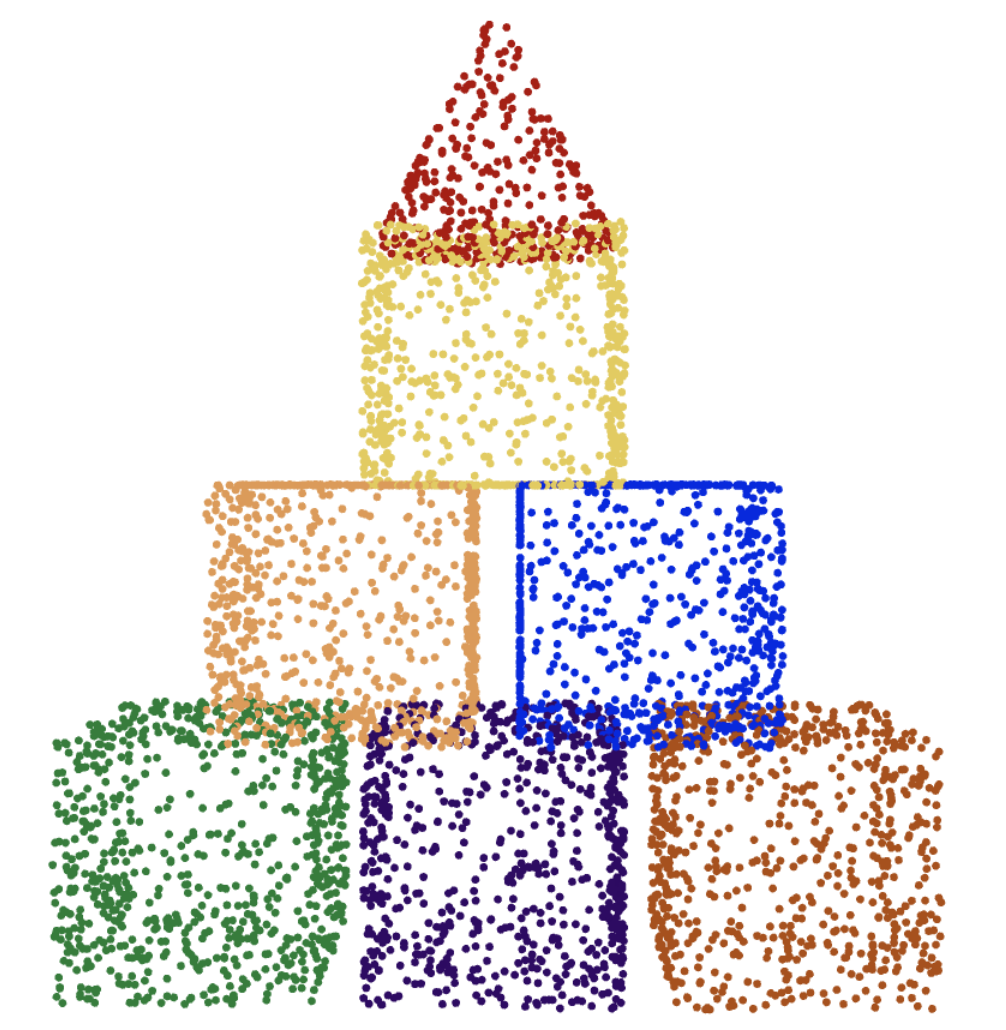

**Визуализация после**

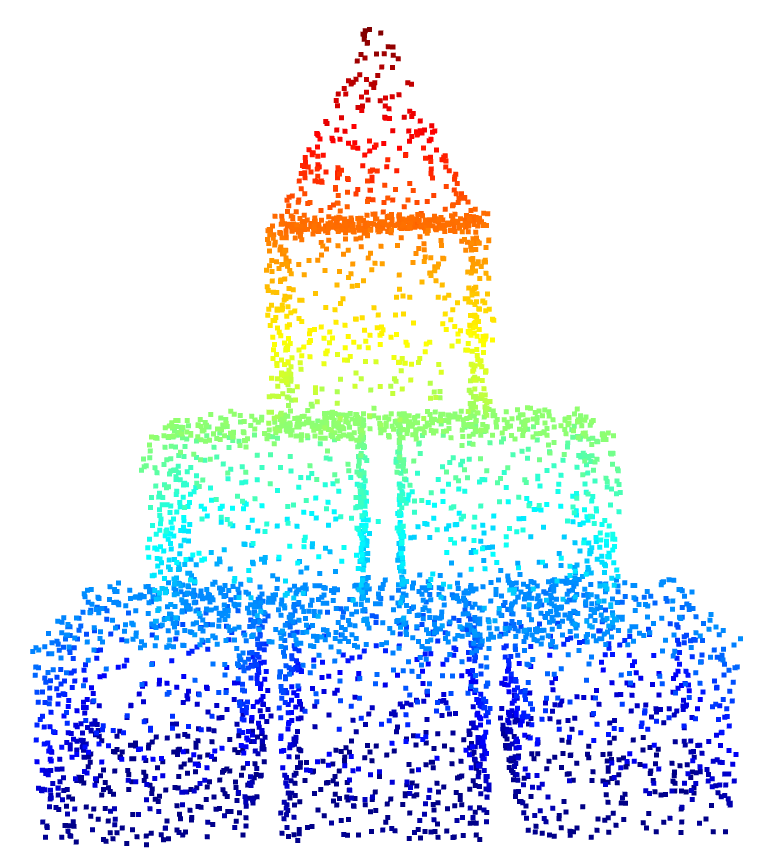
